### Generate a fake really large tree

In [1]:
import pandas as pd

NUM_NODES = 500
NUM_SITES = 4
NAME = f"{NUM_NODES}nodes_f{NUM_SITES}sites_simple"

class TreeNode:
    def __init__(self, val=0, left=None, right=None):
        self.val = val
        self.left = left
        self.right = right

def create_binary_tree(n):
    if n <= 0:
        return None, []
    
    nodes = [TreeNode(i) for i in range(0,n)]
    edges = []
    
    for i in range(n):
        left_index = 2 * i + 1
        right_index = 2 * i + 2
        if left_index < n:
            nodes[i].left = nodes[left_index]
            edges.append((nodes[i].val, nodes[left_index].val))
        if right_index < n:
            nodes[i].right = nodes[right_index]
            edges.append((nodes[i].val, nodes[right_index].val))
    
    return nodes[0], edges

def find_leaf_nodes(root):
    if not root:
        return []
    
    leaves = []
    stack = [root]
    
    while stack:
        node = stack.pop()
        if not node.left and not node.right:
            leaves.append(node.val)
        if node.right:
            stack.append(node.right)
        if node.left:
            stack.append(node.left)
    
    return leaves

def is_descendant(root, x_val, target_val):
    def find_node(node, val):
        if not node:
            return None
        if node.val == val:
            return node
        left_result = find_node(node.left, val)
        return left_result if left_result else find_node(node.right, val)

    def check_descendant(node, target_val):
        if not node:
            return False
        if node.val == target_val:
            return True
        return check_descendant(node.left, target_val) or check_descendant(node.right, target_val)

    x_node = find_node(root, x_val)
    if not x_node:
        return False
    return check_descendant(x_node, target_val)

# Create a binary tree with 100 nodes
root, edges = create_binary_tree(NUM_NODES)
with open(f'outputs/{NAME}.txt', 'w') as f:
    for edge in edges:
        f.write(f"{edge[0]} {edge[1]}")
        f.write("\n")

# Find all leaf nodes
leaf_nodes = find_leaf_nodes(root)
print(len(leaf_nodes))
cols = ['anatomical_site_index','anatomical_site_label','cluster_index','cluster_label','present','site_category','num_mutations']

data = []


sites = ['primary'] + [f'met{x}' for x in range(1,NUM_SITES)]

site_to_subtree_roots = {"primary":[3],"met1":[4], "met2":[6,12,49],  "met3":[23,50]}

print(sites)
for node in range(0,NUM_NODES):
    for i,site in enumerate(sites):
        
        present = 0
        subtree_roots = site_to_subtree_roots[site]
        for subtree_root in subtree_roots:
            if node in leaf_nodes and is_descendant(root, subtree_root, node): 
                present = 1
        
        site_cat = 'primary' if site == 'primary' else 'metastasis'
        data.append([i, site, node, str(node), present, site_cat, 1])

df = pd.DataFrame(data, columns=cols)
df.to_csv(f"outputs/{NAME}.tsv", sep="\t", index=False)
df


250
['primary', 'met1', 'met2', 'met3']


,anatomical_site_index,anatomical_site_label,cluster_index,cluster_label,present,site_category,num_mutations
0,0,primary,0,0,0,primary,1
1,1,met1,0,0,0,metastasis,1
2,2,met2,0,0,0,metastasis,1
3,3,met3,0,0,0,metastasis,1
4,0,primary,1,1,0,primary,1
...,...,...,...,...,...,...,...
1995,3,met3,498,498,0,metastasis,1
1996,0,primary,499,499,0,primary,1
1997,1,met1,499,499,0,metastasis,1
1998,2,met2,499,499,1,metastasis,1


CUDA GPU: False
outputs/500nodes_f4sites_simple.tsv
ordered_sites ['primary', 'met1', 'met2', 'met3']
calculated batch size: 8256


 11%|█         | 50/450 [1:22:51<4:02:22, 36.36s/it] 

second optimization batch size: 286


/lila/data/morrisq/divyak/projects/metient/metient/lib/v_optimizer.py:422: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  known_labelings.append(torch.eye(v_solver.num_sites)[optimal_site].T)
100%|██████████| 450/450 [2:34:58<00:00,  1.47s/it]     

pareto_metrics {(4, 3, 2), (9, 3, 1)}
# final solutions: 2
500nodes_f4sites_simple_primary
1000 unique trees were not found (2 were found). Retry with a higher sample size if you want to get more trees.


/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node '100', graph '%3' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


<Figure size 640x480 with 0 Axes>

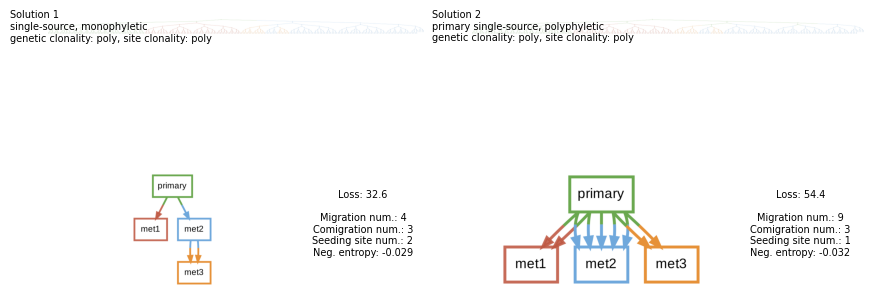

In [2]:
%%prun
from metient.metient import *

evaluate_label_clone_tree(f"outputs/{NAME}.txt", f"outputs/{NAME}.tsv", Weights(), PrintConfig(), "outputs/", NAME, O=None,
                          solve_polytomies=False, batch_size=-1)
